In [139]:
## Hidden Cells
#
#from IPython.display import HTML
#
#HTML('''<script>
#code_show=true; 
#function code_toggle() {
# if (code_show){
# $('div.input').hide();
# } else {
# $('div.input').show();
# }
# code_show = !code_show
#} 
#$( document ).ready(code_toggle);
#</script>
#<form action="javascript:code_toggle()"></form>''')

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries 

In [141]:
!pip install imagecodecs

In [142]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [143]:
from skimage.io import imread, imshow, imsave
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
from skimage.filters.rank import median
from skimage.morphology import disk
from skimage.transform import resize

%matplotlib inline

import os
import shutil

from tqdm import tqdm_notebook as tqdm
import pandas as pd
#import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub

import imagecodecs as ic

# Variables

In [144]:
threshold_to_255 = 215

generalPath = '/content/drive/MyDrive/Offline-Signature-Verification-Project/'.replace('/', os.sep)
datasetName = 'UTSig 10'

img_width = 128
img_height = 128

# Functions

In [145]:
def delimitImage(image):
    
    '''
    Author: Fred Morales
    Description: Generates a delimited image
    Parameters:
        image.- array in gray-scale (0-255)
        
    Return: array delimited
    '''
    
    boolean_version = image == 255

    topLimit, leftLimit, rightLimit, bottomLimit = -1,-1,-1,-1

    for i in range(boolean_version.shape[0]):

        if any([False in boolean_version[i]]):

            topLimit = i
            break

    for i in range(boolean_version.shape[0]-1,0,-1):

        if any([False in boolean_version[i]]):

            bottomLimit = i
            break

    for i in range(boolean_version.shape[1]):

        if any([False in boolean_version[:,i]]):

            leftLimit = i
            break

    for i in range(boolean_version.shape[1]-1,0,-1):

        if any([False in boolean_version[:,i]]):

            rightLimit = i
            break
            
    return image[topLimit:bottomLimit, leftLimit:rightLimit]

# Load image

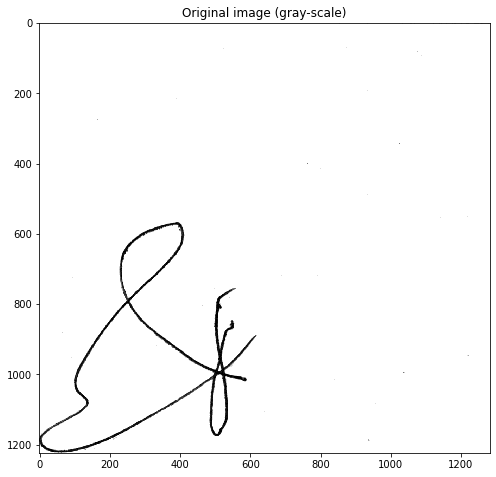

In [146]:
image_gray = ic.imread(generalPath + '12.tif')
#img_new = rgb2gray(img)
plt.figure(figsize=(7,7))
plt.title('Original image (gray-scale)')
imshow(image_gray)

In [147]:
# Image representation 

print('Size: ', image_gray.shape)
print('Data: ', image_gray)

Size:  (1224, 1282)
Data:  [[255 255 255 ... 153 187 187]
 [255 255 255 ... 221 221 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


# Preprocessing

### Example

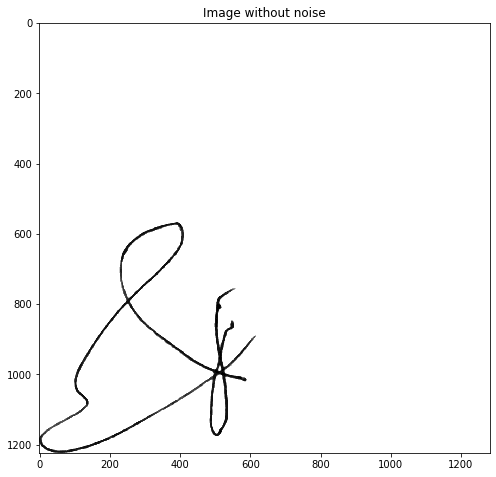

In [148]:
# The median filter is often used for noise removal because borders are preserved

image_Without_Noise = median(image_gray, disk(4))
image_Without_Noise = np.where(image_Without_Noise > threshold_to_255, 255, image_Without_Noise)

plt.figure(figsize=(7,7))
plt.title('Image without noise')
imshow(image_Without_Noise)

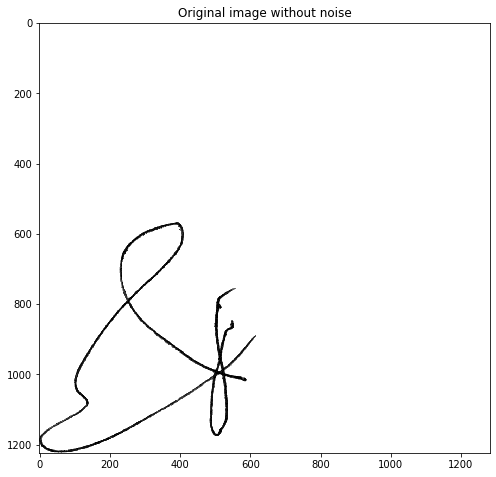

In [149]:
image_gray_without_noise = np.where(image_Without_Noise == 255, 255, image_gray)

plt.figure(figsize=(7,7))
plt.title('Original image without noise')
imshow(image_gray_without_noise)

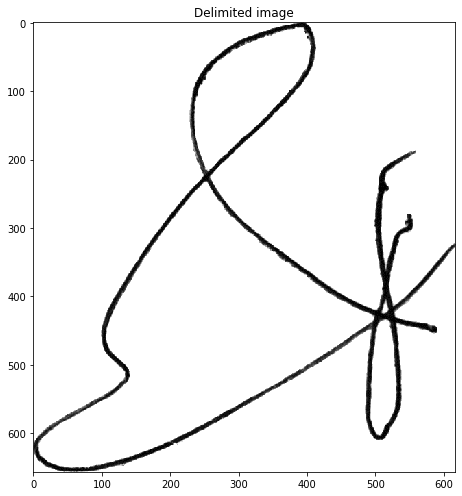

In [150]:
# Delimit the image

image_Without_Noise_delimited = delimitImage(image_gray_without_noise)
        
plt.figure(figsize=(7,7))
plt.title('Delimited image')
imshow(image_Without_Noise_delimited)

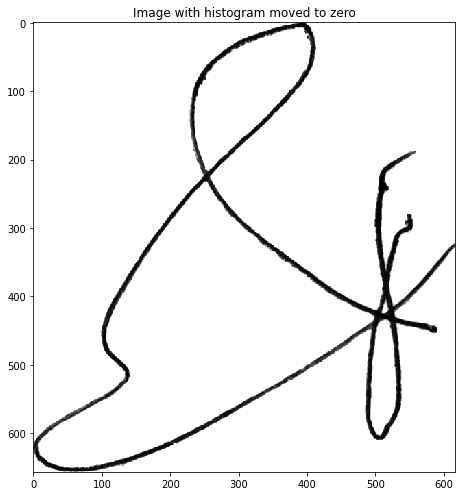

In [151]:
min_value = np.min(image_Without_Noise_delimited)

preprocessed_image = np.where(image_Without_Noise_delimited != 255
                              , image_Without_Noise_delimited - min_value
                              , image_Without_Noise_delimited)

plt.figure(figsize=(7,7))
plt.title('Image with histogram moved to zero')
imshow(preprocessed_image)

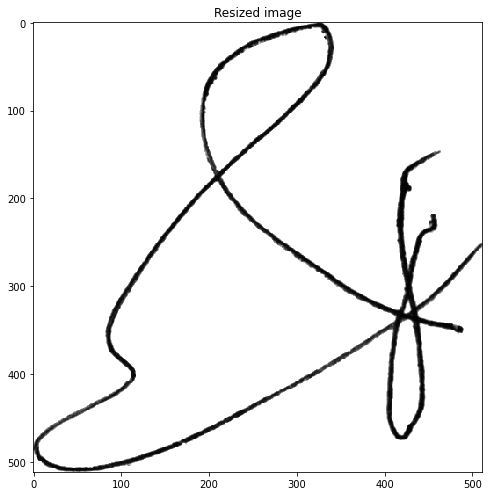

In [152]:
# Resized image

preprocessed_image = np.round(resize(preprocessed_image, (512, 512)) * 255).astype(np.uint8)
preprocessed_image = np.where(preprocessed_image > threshold_to_255, 255, preprocessed_image)

plt.figure(figsize=(7,7))
plt.title('Resized image')
imshow(preprocessed_image)

imsave(generalPath + 'preprocesing_12.png', preprocessed_image)

In [153]:
preprocessed_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [154]:
# Image binarization

#threshold = threshold_otsu(image_Without_Noise_delimited)

#binary = image_Without_Noise_delimited > threshold

#binary = np.uint8(np.where(binary == True, 255, binary))

#plt.figure(figsize=(8,8))
#imshow(binary)

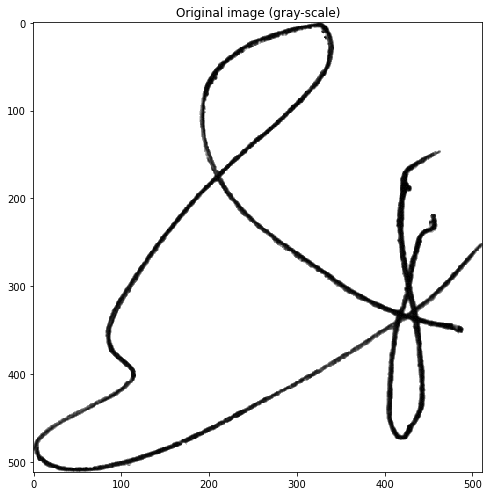

In [155]:
image_gray = imread(generalPath + 'preprocesing_12.png')
plt.figure(figsize=(7,7))
plt.title('Original image (gray-scale)')
imshow(image_gray)

In [156]:
image_gray

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

### Processing dataset

In [157]:
# Directory creation

modelsPath = generalPath + 'Pre-trained models'
targetPath = generalPath + 'Dataset preprocessing'

UTSigPath = targetPath + os.sep + datasetName
UTSig_Genuine_Path = UTSigPath + os.sep + 'Genuine'
UTSig_Forgery_Path = UTSigPath + os.sep + 'Forgery'

total = 0

try:
        
    if not os.path.exists(targetPath):
        
        #shutil.rmtree(targetPath)
        os.mkdir(targetPath)

    if not os.path.exists(UTSigPath):

        os.mkdir(UTSigPath)
        os.mkdir(UTSig_Genuine_Path)
        os.mkdir(UTSig_Forgery_Path)

except OSError as error:
    print(error)
    
sourcePath = generalPath + os.sep.join(['Dataset', datasetName])

for root, directories, files in os.walk(sourcePath, topdown=False):
    for name in files:
        
        total += 1

In [158]:
# Preprocessing all dataset

UTSig_Forgery_Path_List = []
UTSig_Genuine_Path_List = []

isThereFile = False

for root, directories, files in os.walk(UTSigPath, topdown=False):
    if len(files) > 0:
        isThereFile = True
        break

if not isThereFile:

    totalProcessed = 0

    for root, directories, files in os.walk(sourcePath, topdown=False):
        
        for name in tqdm(files, desc ="Preprocessing image: "):
            
            pathImage = os.path.join(root, name)
            
            # Load image and convert gray-scale
            
            image_gray = ic.imread(pathImage)
            
            # Apply median filter
            
            image_Without_Noise = median(image_gray, disk(4))
            image_Without_Noise = np.where(image_Without_Noise > threshold_to_255, 255, image_Without_Noise)
            
            # Original imagen without noise
            
            image_gray_without_noise = np.where(image_Without_Noise == 255, 255, image_gray)
            
            # Delimit the image

            image_Without_Noise_delimited = delimitImage(image_gray_without_noise)
            
            # Image with histogram moved to zero
            
            min_value = np.min(image_Without_Noise_delimited)

            preprocessed_image = np.where(image_Without_Noise_delimited != 255
                                          , image_Without_Noise_delimited - min_value
                                          , image_Without_Noise_delimited)
            
            # Resized image

            preprocessed_image = np.round(resize(preprocessed_image, (512, 512)) * 255).astype(np.uint8)
            preprocessed_image = np.where(preprocessed_image > threshold_to_255, 255, preprocessed_image)
            
            # Save image
            
            pathImage = pathImage.replace('Dataset','Dataset preprocessing')
            
            listFolderName = pathImage.split(os.sep)

            if 'Genuine' in listFolderName:
                pathImage = os.sep.join(listFolderName[:-2]) + os.sep + '_'.join(listFolderName[-2:])
            else:
                pathImage = os.sep.join(listFolderName[:-3]) + os.sep + '_'.join(listFolderName[-3:])

            pathImage = os.path.splitext(pathImage)[0] + '.png'
            
            imsave(pathImage, preprocessed_image)

            totalProcessed += 1

        print('Total procesados: {} de {} ({} %)'.format(totalProcessed, total, round(totalProcessed / total * 100, 2)))

    UTSig_Forgery_Path_List = os.listdir(UTSig_Forgery_Path)
    UTSig_Genuine_Path_List = os.listdir(UTSig_Genuine_Path)

else:

    sourcePath = generalPath + os.sep.join(['Dataset', datasetName])

    for root, directories, files in os.walk(sourcePath, topdown=False):
        for name in files:
            
            pathTemp = os.path.join(root, name)

            listDirectories = pathTemp.split(os.sep)

            if 'Forgery' in pathTemp:

                fileName = '_'.join(listDirectories[-3:]).replace('tif','png')
                UTSig_Forgery_Path_List.append(fileName)

            else:

                fileName = '_'.join(listDirectories[-2:]).replace('tif','png')
                UTSig_Genuine_Path_List.append(fileName)

In [159]:
dfForgery = pd.DataFrame([filename for filename in UTSig_Forgery_Path_List]
                         , columns=['filename'])
dfForgery['class'] = 0

dfGenuine = pd.DataFrame([filename for filename in UTSig_Genuine_Path_List]
                         , columns=['filename'])
dfGenuine['class'] = 1

df = pd.concat([dfForgery, dfGenuine], ignore_index = True)

y = df[['class']]

In [160]:
df[['class']].value_counts()

class
0        450
1        270
dtype: int64

In [161]:
df[['class']].value_counts() / df.shape[0]

class
0        0.625
1        0.375
dtype: float64

In [162]:
df

,filename,class
0,Opposite Hand_1_1.png,0
1,Opposite Hand_1_2.png,0
2,Opposite Hand_1_3.png,0
3,Opposite Hand_10_1.png,0
4,Opposite Hand_10_2.png,0
...,...,...
715,9_5.png,1
716,9_6.png,1
717,9_7.png,1
718,9_8.png,1


In [163]:
if not isThereFile:

    for filename in UTSig_Forgery_Path_List:
      
        shutil.move(os.path.join(UTSig_Forgery_Path, filename), UTSigPath)

    for filename in UTSig_Genuine_Path_List:
        
        shutil.move(os.path.join(UTSig_Genuine_Path, filename), UTSigPath)
        
    shutil.rmtree(UTSig_Genuine_Path)
    shutil.rmtree(UTSig_Forgery_Path)

# Building the CNN

In [165]:
def create_model(pretrained_base_name='inception_v1'):

    model = tf.keras.Sequential([
        
        # Base
        hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/classification/5",
                      trainable=False,
                      input_shape=(img_width, img_height, 3)),

        # Head
        layers.BatchNormalization(renorm=True),
        layers.Flatten(),
        #layers.Dense(256, activation='relu'),
        #layers.Dropout(0.5),
        #layers.BatchNormalization(),
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid'),
    ])
    
    optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    
    return model

Found 576 validated image filenames.
Found 144 validated image filenames.

##############################################
################### Fold #1 ##################
##############################################

Epoch 1/50
18/18 [==============================] - 19s 839ms/step - loss: 0.8247 - binary_accuracy: 0.5538 - val_loss: 0.9189 - val_binary_accuracy: 0.5000

Epoch 00001: val_binary_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 2/50
18/18 [==============================] - 14s 787ms/step - loss: 0.7342 - binary_accuracy: 0.6337 - val_loss: 0.7257 - val_binary_accuracy: 0.5972

Epoch 00002: val_binary_accuracy improved from 0.50000 to 0.59722, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 3/50
18/18 [==============================] - 14s 808ms/step - loss: 0.6619 - binary_accuracy: 0.7014 - val_loss: 0.6646 - val_binary_accuracy: 0.6111

Epoch 00003: val_binary_accuracy improved from 0.59722 to 0.61111, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 4/50
18/18 [==============================] - 14s 792ms/step - loss: 0.6536 - binary_accuracy: 0.6788 - val_loss: 0.6432 - val_binary_accuracy: 0.6458

Epoch 00004: val_binary_accuracy improved from 0.61111 to 0.64583, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 5/50
18/18 [==============================] - 15s 832ms/step - loss: 0.5990 - binary_accuracy: 0.7153 - val_loss: 0.6133 - val_binary_accuracy: 0.6806

Epoch 00005: val_binary_accuracy improved from 0.64583 to 0.68056, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 6/50
18/18 [==============================] - 15s 812ms/step - loss: 0.5943 - binary_accuracy: 0.7188 - val_loss: 0.5900 - val_binary_accuracy: 0.6944

Epoch 00006: val_binary_accuracy improved from 0.68056 to 0.69444, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 7/50
18/18 [==============================] - 16s 863ms/step - loss: 0.5374 - binary_accuracy: 0.7448 - val_loss: 0.5714 - val_binary_accuracy: 0.7222

Epoch 00007: val_binary_accuracy improved from 0.69444 to 0.72222, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 8/50
18/18 [==============================] - 15s 812ms/step - loss: 0.5451 - binary_accuracy: 0.7552 - val_loss: 0.5885 - val_binary_accuracy: 0.7222

Epoch 00008: val_binary_accuracy did not improve from 0.72222
Epoch 9/50
18/18 [==============================] - 14s 805ms/step - loss: 0.5327 - binary_accuracy: 0.7517 - val_loss: 0.5768 - val_binary_accuracy: 0.7153

Epoch 00009: val_binary_accuracy did not improve from 0.72222
Epoch 10/50
18/18 [==============================] - 14s 795ms/step - loss: 0.5323 - binary_accuracy: 0.7795 - val_loss: 0.5678 - val_binary_accuracy: 0.7083

Epoch 00010: val_binary_accuracy did not improve from 0.72222
Epoch 11/50
18/18 [==============================] - 15s 860ms/step - loss: 0.5076 - binary_accuracy: 0.7795 - val_loss: 0.5567 - val_binary_accuracy: 0.7083

Epoch 00011: val_binary_accuracy did not improve from 0.72222
Epoch 12/50
18/18 [==============================] - 14s 807ms/step - loss: 0.4915 - binary_accuracy: 0.7986 - val_los

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 15/50
18/18 [==============================] - 16s 883ms/step - loss: 0.4617 - binary_accuracy: 0.7865 - val_loss: 0.5066 - val_binary_accuracy: 0.7361

Epoch 00015: val_binary_accuracy did not improve from 0.73611
Epoch 16/50
18/18 [==============================] - 16s 873ms/step - loss: 0.4741 - binary_accuracy: 0.7917 - val_loss: 0.4910 - val_binary_accuracy: 0.7361

Epoch 00016: val_binary_accuracy did not improve from 0.73611
Epoch 17/50
18/18 [==============================] - 15s 820ms/step - loss: 0.4416 - binary_accuracy: 0.7934 - val_loss: 0.4909 - val_binary_accuracy: 0.7431

Epoch 00017: val_binary_accuracy improved from 0.73611 to 0.74306, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 18/50
18/18 [==============================] - 15s 837ms/step - loss: 0.4224 - binary_accuracy: 0.8247 - val_loss: 0.4971 - val_binary_accuracy: 0.7361

Epoch 00018: val_binary_accuracy did not improve from 0.74306
Epoch 19/50
18/18 [==============================] - 15s 822ms/step - loss: 0.4282 - binary_accuracy: 0.8142 - val_loss: 0.4801 - val_binary_accuracy: 0.7431

Epoch 00019: val_binary_accuracy did not improve from 0.74306
Epoch 20/50
18/18 [==============================] - 14s 802ms/step - loss: 0.4197 - binary_accuracy: 0.8385 - val_loss: 0.4647 - val_binary_accuracy: 0.7500

Epoch 00020: val_binary_accuracy improved from 0.74306 to 0.75000, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 21/50
18/18 [==============================] - 14s 805ms/step - loss: 0.4116 - binary_accuracy: 0.8194 - val_loss: 0.4670 - val_binary_accuracy: 0.7500

Epoch 00021: val_binary_accuracy did not improve from 0.75000
Epoch 22/50
18/18 [==============================] - 15s 809ms/step - loss: 0.4126 - binary_accuracy: 0.8194 - val_loss: 0.4717 - val_binary_accuracy: 0.7431

Epoch 00022: val_binary_accuracy did not improve from 0.75000
Epoch 23/50
18/18 [==============================] - 15s 829ms/step - loss: 0.4504 - binary_accuracy: 0.7917 - val_loss: 0.4552 - val_binary_accuracy: 0.7708

Epoch 00023: val_binary_accuracy improved from 0.75000 to 0.77083, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 24/50
18/18 [==============================] - 15s 842ms/step - loss: 0.4031 - binary_accuracy: 0.8351 - val_loss: 0.4530 - val_binary_accuracy: 0.7569

Epoch 00024: val_binary_accuracy did not improve from 0.77083
Epoch 25/50
18/18 [==============================] - 15s 848ms/step - loss: 0.4203 - binary_accuracy: 0.8299 - val_loss: 0.4362 - val_binary_accuracy: 0.7639

Epoch 00025: val_binary_accuracy did not improve from 0.77083
Epoch 26/50
18/18 [==============================] - 15s 854ms/step - loss: 0.3659 - binary_accuracy: 0.8628 - val_loss: 0.4309 - val_binary_accuracy: 0.7569

Epoch 00026: val_binary_accuracy did not improve from 0.77083
Epoch 27/50
18/18 [==============================] - 15s 832ms/step - loss: 0.3716 - binary_accuracy: 0.8611 - val_loss: 0.4207 - val_binary_accuracy: 0.7778

Epoch 00027: val_binary_accuracy improved from 0.77083 to 0.77778, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.c

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 28/50
18/18 [==============================] - 15s 848ms/step - loss: 0.3711 - binary_accuracy: 0.8385 - val_loss: 0.4222 - val_binary_accuracy: 0.7708

Epoch 00028: val_binary_accuracy did not improve from 0.77778
Epoch 29/50
18/18 [==============================] - 17s 972ms/step - loss: 0.3667 - binary_accuracy: 0.8385 - val_loss: 0.4206 - val_binary_accuracy: 0.7778

Epoch 00029: val_binary_accuracy did not improve from 0.77778
Epoch 30/50
18/18 [==============================] - 15s 846ms/step - loss: 0.3675 - binary_accuracy: 0.8594 - val_loss: 0.4112 - val_binary_accuracy: 0.7847

Epoch 00030: val_binary_accuracy improved from 0.77778 to 0.78472, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 31/50
18/18 [==============================] - 16s 869ms/step - loss: 0.3501 - binary_accuracy: 0.8559 - val_loss: 0.4092 - val_binary_accuracy: 0.7778

Epoch 00031: val_binary_accuracy did not improve from 0.78472
Epoch 32/50
18/18 [==============================] - 15s 859ms/step - loss: 0.3733 - binary_accuracy: 0.8507 - val_loss: 0.3993 - val_binary_accuracy: 0.7708

Epoch 00032: val_binary_accuracy did not improve from 0.78472
Epoch 33/50
18/18 [==============================] - 15s 849ms/step - loss: 0.3594 - binary_accuracy: 0.8559 - val_loss: 0.4013 - val_binary_accuracy: 0.8125

Epoch 00033: val_binary_accuracy improved from 0.78472 to 0.81250, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 34/50
18/18 [==============================] - 15s 864ms/step - loss: 0.3689 - binary_accuracy: 0.8281 - val_loss: 0.4099 - val_binary_accuracy: 0.8056

Epoch 00034: val_binary_accuracy did not improve from 0.81250
Epoch 35/50
18/18 [==============================] - 18s 984ms/step - loss: 0.3487 - binary_accuracy: 0.8663 - val_loss: 0.3987 - val_binary_accuracy: 0.8264

Epoch 00035: val_binary_accuracy improved from 0.81250 to 0.82639, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 36/50
18/18 [==============================] - 16s 876ms/step - loss: 0.3409 - binary_accuracy: 0.8628 - val_loss: 0.3955 - val_binary_accuracy: 0.7986

Epoch 00036: val_binary_accuracy did not improve from 0.82639
Epoch 37/50
18/18 [==============================] - 15s 853ms/step - loss: 0.3489 - binary_accuracy: 0.8507 - val_loss: 0.3895 - val_binary_accuracy: 0.8264

Epoch 00037: val_binary_accuracy did not improve from 0.82639
Epoch 38/50
18/18 [==============================] - 15s 850ms/step - loss: 0.3591 - binary_accuracy: 0.8576 - val_loss: 0.3995 - val_binary_accuracy: 0.7986

Epoch 00038: val_binary_accuracy did not improve from 0.82639
Epoch 39/50
18/18 [==============================] - 17s 975ms/step - loss: 0.3377 - binary_accuracy: 0.8628 - val_loss: 0.4198 - val_binary_accuracy: 0.7917

Epoch 00039: val_binary_accuracy did not improve from 0.82639
Epoch 40/50
18/18 [==============================] - 17s 950ms/step - loss: 0.3620 - binary_accuracy: 0.8542 - val_l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 2/50
18/18 [==============================] - 17s 960ms/step - loss: 0.7019 - binary_accuracy: 0.5885 - val_loss: 0.6366 - val_binary_accuracy: 0.6319

Epoch 00002: val_binary_accuracy did not improve from 0.65278
Epoch 3/50
18/18 [==============================] - 15s 851ms/step - loss: 0.6534 - binary_accuracy: 0.6424 - val_loss: 0.6232 - val_binary_accuracy: 0.6806

Epoch 00003: val_binary_accuracy improved from 0.65278 to 0.68056, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 4/50
18/18 [==============================] - 15s 840ms/step - loss: 0.6189 - binary_accuracy: 0.6493 - val_loss: 0.6007 - val_binary_accuracy: 0.6875

Epoch 00004: val_binary_accuracy improved from 0.68056 to 0.68750, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 5/50
18/18 [==============================] - 15s 849ms/step - loss: 0.5999 - binary_accuracy: 0.7031 - val_loss: 0.5938 - val_binary_accuracy: 0.7292

Epoch 00005: val_binary_accuracy improved from 0.68750 to 0.72917, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 6/50
18/18 [==============================] - 15s 843ms/step - loss: 0.6019 - binary_accuracy: 0.6684 - val_loss: 0.5900 - val_binary_accuracy: 0.7500

Epoch 00006: val_binary_accuracy improved from 0.72917 to 0.75000, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 7/50
18/18 [==============================] - 15s 850ms/step - loss: 0.6384 - binary_accuracy: 0.6701 - val_loss: 0.5750 - val_binary_accuracy: 0.7361

Epoch 00007: val_binary_accuracy did not improve from 0.75000
Epoch 8/50
18/18 [==============================] - 15s 831ms/step - loss: 0.5744 - binary_accuracy: 0.7135 - val_loss: 0.5914 - val_binary_accuracy: 0.7639

Epoch 00008: val_binary_accuracy improved from 0.75000 to 0.76389, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 9/50
18/18 [==============================] - 17s 960ms/step - loss: 0.5727 - binary_accuracy: 0.7309 - val_loss: 0.5672 - val_binary_accuracy: 0.7639

Epoch 00009: val_binary_accuracy did not improve from 0.76389
Epoch 10/50
18/18 [==============================] - 15s 847ms/step - loss: 0.5624 - binary_accuracy: 0.7014 - val_loss: 0.5551 - val_binary_accuracy: 0.7569

Epoch 00010: val_binary_accuracy did not improve from 0.76389
Epoch 11/50
18/18 [==============================] - 15s 838ms/step - loss: 0.5494 - binary_accuracy: 0.7326 - val_loss: 0.5665 - val_binary_accuracy: 0.7847

Epoch 00011: val_binary_accuracy improved from 0.76389 to 0.78472, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 12/50
18/18 [==============================] - 15s 839ms/step - loss: 0.4995 - binary_accuracy: 0.7431 - val_loss: 0.5587 - val_binary_accuracy: 0.7847

Epoch 00012: val_binary_accuracy did not improve from 0.78472
Epoch 13/50
18/18 [==============================] - 15s 812ms/step - loss: 0.5218 - binary_accuracy: 0.7257 - val_loss: 0.5468 - val_binary_accuracy: 0.7847

Epoch 00013: val_binary_accuracy did not improve from 0.78472
Epoch 14/50
18/18 [==============================] - 15s 848ms/step - loss: 0.4773 - binary_accuracy: 0.7517 - val_loss: 0.5297 - val_binary_accuracy: 0.7778

Epoch 00014: val_binary_accuracy did not improve from 0.78472
Epoch 15/50
18/18 [==============================] - 17s 961ms/step - loss: 0.4661 - binary_accuracy: 0.7760 - val_loss: 0.5184 - val_binary_accuracy: 0.7778

Epoch 00015: val_binary_accuracy did not improve from 0.78472
Epoch 16/50
18/18 [==============================] - 15s 852ms/step - loss: 0.4678 - binary_accuracy: 0.7899 - val_l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 17/50
18/18 [==============================] - 15s 839ms/step - loss: 0.4286 - binary_accuracy: 0.8021 - val_loss: 0.5068 - val_binary_accuracy: 0.7847

Epoch 00017: val_binary_accuracy did not improve from 0.79861
Epoch 18/50
18/18 [==============================] - 15s 843ms/step - loss: 0.4293 - binary_accuracy: 0.7986 - val_loss: 0.5037 - val_binary_accuracy: 0.7847

Epoch 00018: val_binary_accuracy did not improve from 0.79861
Epoch 19/50
18/18 [==============================] - 17s 961ms/step - loss: 0.4398 - binary_accuracy: 0.7830 - val_loss: 0.4933 - val_binary_accuracy: 0.7986

Epoch 00019: val_binary_accuracy did not improve from 0.79861
Epoch 20/50
18/18 [==============================] - 15s 828ms/step - loss: 0.4015 - binary_accuracy: 0.8142 - val_loss: 0.4925 - val_binary_accuracy: 0.7847

Epoch 00020: val_binary_accuracy did not improve from 0.79861
Epoch 21/50
18/18 [==============================] - 15s 834ms/step - loss: 0.3730 - binary_accuracy: 0.8160 - val_l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 2/50
18/18 [==============================] - 15s 818ms/step - loss: 0.7431 - binary_accuracy: 0.6267 - val_loss: 0.6401 - val_binary_accuracy: 0.6736

Epoch 00002: val_binary_accuracy improved from 0.59722 to 0.67361, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 3/50
18/18 [==============================] - 15s 825ms/step - loss: 0.7063 - binary_accuracy: 0.6545 - val_loss: 0.5833 - val_binary_accuracy: 0.7500

Epoch 00003: val_binary_accuracy improved from 0.67361 to 0.75000, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 4/50
18/18 [==============================] - 15s 832ms/step - loss: 0.6390 - binary_accuracy: 0.6962 - val_loss: 0.5758 - val_binary_accuracy: 0.7361

Epoch 00004: val_binary_accuracy did not improve from 0.75000
Epoch 5/50
18/18 [==============================] - 15s 832ms/step - loss: 0.6555 - binary_accuracy: 0.6840 - val_loss: 0.5656 - val_binary_accuracy: 0.7500

Epoch 00005: val_binary_accuracy did not improve from 0.75000
Epoch 6/50
18/18 [==============================] - 15s 813ms/step - loss: 0.5946 - binary_accuracy: 0.7083 - val_loss: 0.5283 - val_binary_accuracy: 0.7639

Epoch 00006: val_binary_accuracy improved from 0.75000 to 0.76389, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 7/50
18/18 [==============================] - 15s 839ms/step - loss: 0.5802 - binary_accuracy: 0.7066 - val_loss: 0.5141 - val_binary_accuracy: 0.7361

Epoch 00007: val_binary_accuracy did not improve from 0.76389
Epoch 8/50
18/18 [==============================] - 15s 835ms/step - loss: 0.6232 - binary_accuracy: 0.6927 - val_loss: 0.5041 - val_binary_accuracy: 0.7569

Epoch 00008: val_binary_accuracy did not improve from 0.76389
Epoch 9/50
18/18 [==============================] - 15s 828ms/step - loss: 0.5736 - binary_accuracy: 0.7431 - val_loss: 0.4838 - val_binary_accuracy: 0.7917

Epoch 00009: val_binary_accuracy improved from 0.76389 to 0.79167, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 10/50
18/18 [==============================] - 15s 836ms/step - loss: 0.5738 - binary_accuracy: 0.7448 - val_loss: 0.4781 - val_binary_accuracy: 0.8333

Epoch 00010: val_binary_accuracy improved from 0.79167 to 0.83333, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 11/50
18/18 [==============================] - 15s 829ms/step - loss: 0.5519 - binary_accuracy: 0.7517 - val_loss: 0.4731 - val_binary_accuracy: 0.8194

Epoch 00011: val_binary_accuracy did not improve from 0.83333
Epoch 12/50
18/18 [==============================] - 15s 837ms/step - loss: 0.5358 - binary_accuracy: 0.7344 - val_loss: 0.4690 - val_binary_accuracy: 0.8333

Epoch 00012: val_binary_accuracy did not improve from 0.83333
Epoch 13/50
18/18 [==============================] - 15s 837ms/step - loss: 0.5151 - binary_accuracy: 0.7604 - val_loss: 0.4616 - val_binary_accuracy: 0.8194

Epoch 00013: val_binary_accuracy did not improve from 0.83333
Epoch 14/50
18/18 [==============================] - 15s 838ms/step - loss: 0.5390 - binary_accuracy: 0.7535 - val_loss: 0.4509 - val_binary_accuracy: 0.8194

Epoch 00014: val_binary_accuracy did not improve from 0.83333
Epoch 15/50
18/18 [==============================] - 15s 834ms/step - loss: 0.4821 - binary_accuracy: 0.7812 - val_l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 22/50
18/18 [==============================] - 15s 833ms/step - loss: 0.4426 - binary_accuracy: 0.8073 - val_loss: 0.3993 - val_binary_accuracy: 0.8056

Epoch 00022: val_binary_accuracy did not improve from 0.84028
Epoch 23/50
18/18 [==============================] - 15s 838ms/step - loss: 0.4492 - binary_accuracy: 0.7743 - val_loss: 0.3918 - val_binary_accuracy: 0.8056

Epoch 00023: val_binary_accuracy did not improve from 0.84028
Epoch 24/50
18/18 [==============================] - 17s 940ms/step - loss: 0.4152 - binary_accuracy: 0.8333 - val_loss: 0.3917 - val_binary_accuracy: 0.8125

Epoch 00024: val_binary_accuracy did not improve from 0.84028
Epoch 25/50
18/18 [==============================] - 15s 826ms/step - loss: 0.4163 - binary_accuracy: 0.8194 - val_loss: 0.3881 - val_binary_accuracy: 0.7986

Epoch 00025: val_binary_accuracy did not improve from 0.84028
Epoch 26/50
18/18 [==============================] - 15s 828ms/step - loss: 0.4534 - binary_accuracy: 0.7882 - val_l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 34/50
18/18 [==============================] - 15s 857ms/step - loss: 0.3864 - binary_accuracy: 0.8420 - val_loss: 0.3863 - val_binary_accuracy: 0.8681

Epoch 00034: val_binary_accuracy did not improve from 0.86806
Epoch 35/50
18/18 [==============================] - 15s 835ms/step - loss: 0.3822 - binary_accuracy: 0.8333 - val_loss: 0.3793 - val_binary_accuracy: 0.8542

Epoch 00035: val_binary_accuracy did not improve from 0.86806
Epoch 36/50
18/18 [==============================] - 15s 833ms/step - loss: 0.3624 - binary_accuracy: 0.8542 - val_loss: 0.3924 - val_binary_accuracy: 0.8542

Epoch 00036: val_binary_accuracy did not improve from 0.86806
Epoch 37/50
18/18 [==============================] - 15s 833ms/step - loss: 0.3786 - binary_accuracy: 0.8333 - val_loss: 0.3822 - val_binary_accuracy: 0.8542

Epoch 00037: val_binary_accuracy did not improve from 0.86806
Epoch 38/50
18/18 [==============================] - 15s 838ms/step - loss: 0.3422 - binary_accuracy: 0.8542 - val_l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 47/50
18/18 [==============================] - 17s 955ms/step - loss: 0.3289 - binary_accuracy: 0.8559 - val_loss: 0.3793 - val_binary_accuracy: 0.8333

Epoch 00047: val_binary_accuracy did not improve from 0.87500
Epoch 48/50
18/18 [==============================] - 15s 836ms/step - loss: 0.3269 - binary_accuracy: 0.8542 - val_loss: 0.3938 - val_binary_accuracy: 0.7986

Epoch 00048: val_binary_accuracy did not improve from 0.87500
Epoch 49/50
18/18 [==============================] - 17s 945ms/step - loss: 0.3400 - binary_accuracy: 0.8594 - val_loss: 0.3801 - val_binary_accuracy: 0.8194

Epoch 00049: val_binary_accuracy did not improve from 0.87500
Epoch 50/50
18/18 [==============================] - 15s 833ms/step - loss: 0.3159 - binary_accuracy: 0.8524 - val_loss: 0.3875 - val_binary_accuracy: 0.8264

Epoch 00050: val_binary_accuracy did not improve from 0.87500
5/5 [==============================] - 3s 563ms/step - loss: 0.3627 - binary_accuracy: 0.8750
Found 576 validated im

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 2/50
18/18 [==============================] - 15s 829ms/step - loss: 0.7539 - binary_accuracy: 0.5122 - val_loss: 0.6668 - val_binary_accuracy: 0.5903

Epoch 00002: val_binary_accuracy improved from 0.54167 to 0.59028, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 3/50
18/18 [==============================] - 15s 824ms/step - loss: 0.6927 - binary_accuracy: 0.5816 - val_loss: 0.6478 - val_binary_accuracy: 0.6319

Epoch 00003: val_binary_accuracy improved from 0.59028 to 0.63194, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 4/50
18/18 [==============================] - 15s 821ms/step - loss: 0.6704 - binary_accuracy: 0.5955 - val_loss: 0.6281 - val_binary_accuracy: 0.6667

Epoch 00004: val_binary_accuracy improved from 0.63194 to 0.66667, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 5/50
18/18 [==============================] - 15s 818ms/step - loss: 0.6317 - binary_accuracy: 0.6198 - val_loss: 0.6084 - val_binary_accuracy: 0.6944

Epoch 00005: val_binary_accuracy improved from 0.66667 to 0.69444, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 6/50
18/18 [==============================] - 15s 833ms/step - loss: 0.6274 - binary_accuracy: 0.6528 - val_loss: 0.5865 - val_binary_accuracy: 0.7222

Epoch 00006: val_binary_accuracy improved from 0.69444 to 0.72222, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 7/50
18/18 [==============================] - 15s 823ms/step - loss: 0.6092 - binary_accuracy: 0.6788 - val_loss: 0.5723 - val_binary_accuracy: 0.7361

Epoch 00007: val_binary_accuracy improved from 0.72222 to 0.73611, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 8/50
18/18 [==============================] - 15s 818ms/step - loss: 0.5871 - binary_accuracy: 0.6771 - val_loss: 0.5637 - val_binary_accuracy: 0.7569

Epoch 00008: val_binary_accuracy improved from 0.73611 to 0.75694, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 9/50
18/18 [==============================] - 15s 818ms/step - loss: 0.5863 - binary_accuracy: 0.6962 - val_loss: 0.5557 - val_binary_accuracy: 0.7569

Epoch 00009: val_binary_accuracy did not improve from 0.75694
Epoch 10/50
18/18 [==============================] - 15s 827ms/step - loss: 0.5683 - binary_accuracy: 0.7188 - val_loss: 0.5403 - val_binary_accuracy: 0.7500

Epoch 00010: val_binary_accuracy did not improve from 0.75694
Epoch 11/50
18/18 [==============================] - 15s 816ms/step - loss: 0.5513 - binary_accuracy: 0.7274 - val_loss: 0.5363 - val_binary_accuracy: 0.7431

Epoch 00011: val_binary_accuracy did not improve from 0.75694
Epoch 12/50
18/18 [==============================] - 17s 943ms/step - loss: 0.5389 - binary_accuracy: 0.7326 - val_loss: 0.5257 - val_binary_accuracy: 0.7431

Epoch 00012: val_binary_accuracy did not improve from 0.75694
Epoch 13/50
18/18 [==============================] - 15s 823ms/step - loss: 0.5289 - binary_accuracy: 0.7674 - val_lo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 16/50
18/18 [==============================] - 15s 837ms/step - loss: 0.5068 - binary_accuracy: 0.7622 - val_loss: 0.5000 - val_binary_accuracy: 0.7639

Epoch 00016: val_binary_accuracy did not improve from 0.77083
Epoch 17/50
18/18 [==============================] - 17s 957ms/step - loss: 0.5187 - binary_accuracy: 0.7552 - val_loss: 0.4907 - val_binary_accuracy: 0.7847

Epoch 00017: val_binary_accuracy improved from 0.77083 to 0.78472, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 18/50
18/18 [==============================] - 15s 823ms/step - loss: 0.4867 - binary_accuracy: 0.7969 - val_loss: 0.4816 - val_binary_accuracy: 0.7778

Epoch 00018: val_binary_accuracy did not improve from 0.78472
Epoch 19/50
18/18 [==============================] - 15s 827ms/step - loss: 0.4743 - binary_accuracy: 0.7865 - val_loss: 0.4751 - val_binary_accuracy: 0.7639

Epoch 00019: val_binary_accuracy did not improve from 0.78472
Epoch 20/50
18/18 [==============================] - 17s 944ms/step - loss: 0.4788 - binary_accuracy: 0.7847 - val_loss: 0.4751 - val_binary_accuracy: 0.7708

Epoch 00020: val_binary_accuracy did not improve from 0.78472
Epoch 21/50
18/18 [==============================] - 15s 821ms/step - loss: 0.4717 - binary_accuracy: 0.7830 - val_loss: 0.4688 - val_binary_accuracy: 0.7708

Epoch 00021: val_binary_accuracy did not improve from 0.78472
Epoch 22/50
18/18 [==============================] - 15s 820ms/step - loss: 0.4649 - binary_accuracy: 0.7726 - val_l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 23/50
18/18 [==============================] - 17s 947ms/step - loss: 0.4627 - binary_accuracy: 0.7812 - val_loss: 0.4576 - val_binary_accuracy: 0.7778

Epoch 00023: val_binary_accuracy did not improve from 0.79167
Epoch 24/50
18/18 [==============================] - 15s 820ms/step - loss: 0.4435 - binary_accuracy: 0.8247 - val_loss: 0.4500 - val_binary_accuracy: 0.7708

Epoch 00024: val_binary_accuracy did not improve from 0.79167
Epoch 25/50
18/18 [==============================] - 17s 948ms/step - loss: 0.4469 - binary_accuracy: 0.8229 - val_loss: 0.4417 - val_binary_accuracy: 0.7639

Epoch 00025: val_binary_accuracy did not improve from 0.79167
Epoch 26/50
18/18 [==============================] - 15s 812ms/step - loss: 0.4353 - binary_accuracy: 0.8073 - val_loss: 0.4434 - val_binary_accuracy: 0.7847

Epoch 00026: val_binary_accuracy did not improve from 0.79167
Epoch 27/50
18/18 [==============================] - 15s 814ms/step - loss: 0.4333 - binary_accuracy: 0.8194 - val_l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 30/50
18/18 [==============================] - 15s 816ms/step - loss: 0.4030 - binary_accuracy: 0.8299 - val_loss: 0.4137 - val_binary_accuracy: 0.7917

Epoch 00030: val_binary_accuracy did not improve from 0.80556
Epoch 31/50
18/18 [==============================] - 15s 822ms/step - loss: 0.3920 - binary_accuracy: 0.8333 - val_loss: 0.4199 - val_binary_accuracy: 0.7778

Epoch 00031: val_binary_accuracy did not improve from 0.80556
Epoch 32/50
18/18 [==============================] - 15s 813ms/step - loss: 0.3976 - binary_accuracy: 0.8160 - val_loss: 0.4173 - val_binary_accuracy: 0.7778

Epoch 00032: val_binary_accuracy did not improve from 0.80556
Epoch 33/50
18/18 [==============================] - 15s 827ms/step - loss: 0.3779 - binary_accuracy: 0.8368 - val_loss: 0.4019 - val_binary_accuracy: 0.7986

Epoch 00033: val_binary_accuracy did not improve from 0.80556
Epoch 34/50
18/18 [==============================] - 15s 816ms/step - loss: 0.3763 - binary_accuracy: 0.8385 - val_l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 35/50
18/18 [==============================] - 15s 825ms/step - loss: 0.3861 - binary_accuracy: 0.8281 - val_loss: 0.3917 - val_binary_accuracy: 0.7917

Epoch 00035: val_binary_accuracy did not improve from 0.81250
Epoch 36/50
18/18 [==============================] - 17s 935ms/step - loss: 0.3766 - binary_accuracy: 0.8507 - val_loss: 0.3809 - val_binary_accuracy: 0.7917

Epoch 00036: val_binary_accuracy did not improve from 0.81250
Epoch 37/50
18/18 [==============================] - 17s 949ms/step - loss: 0.3555 - binary_accuracy: 0.8576 - val_loss: 0.3767 - val_binary_accuracy: 0.8333

Epoch 00037: val_binary_accuracy improved from 0.81250 to 0.83333, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 38/50
18/18 [==============================] - 15s 827ms/step - loss: 0.3783 - binary_accuracy: 0.8333 - val_loss: 0.3822 - val_binary_accuracy: 0.8333

Epoch 00038: val_binary_accuracy did not improve from 0.83333
Epoch 39/50
18/18 [==============================] - 17s 949ms/step - loss: 0.3564 - binary_accuracy: 0.8542 - val_loss: 0.3821 - val_binary_accuracy: 0.8125

Epoch 00039: val_binary_accuracy did not improve from 0.83333
Epoch 40/50
18/18 [==============================] - 15s 820ms/step - loss: 0.3638 - binary_accuracy: 0.8524 - val_loss: 0.3758 - val_binary_accuracy: 0.8125

Epoch 00040: val_binary_accuracy did not improve from 0.83333
Epoch 41/50
18/18 [==============================] - 17s 952ms/step - loss: 0.3582 - binary_accuracy: 0.8420 - val_loss: 0.3718 - val_binary_accuracy: 0.8472

Epoch 00041: val_binary_accuracy improved from 0.83333 to 0.84722, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.c

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 42/50
18/18 [==============================] - 17s 952ms/step - loss: 0.3697 - binary_accuracy: 0.8403 - val_loss: 0.3650 - val_binary_accuracy: 0.8194

Epoch 00042: val_binary_accuracy did not improve from 0.84722
Epoch 43/50
18/18 [==============================] - 15s 811ms/step - loss: 0.3438 - binary_accuracy: 0.8472 - val_loss: 0.3625 - val_binary_accuracy: 0.8333

Epoch 00043: val_binary_accuracy did not improve from 0.84722
Epoch 44/50
18/18 [==============================] - 15s 812ms/step - loss: 0.3320 - binary_accuracy: 0.8628 - val_loss: 0.3633 - val_binary_accuracy: 0.8333

Epoch 00044: val_binary_accuracy did not improve from 0.84722
Epoch 45/50
18/18 [==============================] - 15s 811ms/step - loss: 0.3313 - binary_accuracy: 0.8646 - val_loss: 0.3564 - val_binary_accuracy: 0.8125

Epoch 00045: val_binary_accuracy did not improve from 0.84722
Epoch 46/50
18/18 [==============================] - 15s 813ms/step - loss: 0.3213 - binary_accuracy: 0.8715 - val_l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 49/50
18/18 [==============================] - 15s 839ms/step - loss: 0.3270 - binary_accuracy: 0.8698 - val_loss: 0.3386 - val_binary_accuracy: 0.8472

Epoch 00049: val_binary_accuracy did not improve from 0.85417
Epoch 50/50
18/18 [==============================] - 15s 819ms/step - loss: 0.3269 - binary_accuracy: 0.8628 - val_loss: 0.3393 - val_binary_accuracy: 0.8819

Epoch 00050: val_binary_accuracy improved from 0.85417 to 0.88194, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


5/5 [==============================] - 3s 558ms/step - loss: 0.3393 - binary_accuracy: 0.8819
Found 576 validated image filenames.
Found 144 validated image filenames.

##############################################
################### Fold #5 ##################
##############################################

Epoch 1/50
18/18 [==============================] - 21s 871ms/step - loss: 0.8791 - binary_accuracy: 0.5035 - val_loss: 0.9446 - val_binary_accuracy: 0.6181

Epoch 00001: val_binary_accuracy improved from -inf to 0.61806, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 2/50
18/18 [==============================] - 15s 833ms/step - loss: 0.8001 - binary_accuracy: 0.5295 - val_loss: 0.6848 - val_binary_accuracy: 0.6111

Epoch 00002: val_binary_accuracy did not improve from 0.61806
Epoch 3/50
18/18 [==============================] - 17s 958ms/step - loss: 0.7252 - binary_accuracy: 0.5729 - val_loss: 0.5596 - val_binary_accuracy: 0.6597

Epoch 00003: val_binary_accuracy improved from 0.61806 to 0.65972, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 4/50
18/18 [==============================] - 17s 957ms/step - loss: 0.6818 - binary_accuracy: 0.5851 - val_loss: 0.5373 - val_binary_accuracy: 0.7083

Epoch 00004: val_binary_accuracy improved from 0.65972 to 0.70833, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 5/50
18/18 [==============================] - 15s 814ms/step - loss: 0.6486 - binary_accuracy: 0.6146 - val_loss: 0.5311 - val_binary_accuracy: 0.7361

Epoch 00005: val_binary_accuracy improved from 0.70833 to 0.73611, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 6/50
18/18 [==============================] - 17s 948ms/step - loss: 0.5907 - binary_accuracy: 0.6476 - val_loss: 0.5149 - val_binary_accuracy: 0.7639

Epoch 00006: val_binary_accuracy improved from 0.73611 to 0.76389, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 7/50
18/18 [==============================] - 17s 961ms/step - loss: 0.6138 - binary_accuracy: 0.6337 - val_loss: 0.5088 - val_binary_accuracy: 0.7500

Epoch 00007: val_binary_accuracy did not improve from 0.76389
Epoch 8/50
18/18 [==============================] - 17s 951ms/step - loss: 0.5817 - binary_accuracy: 0.6719 - val_loss: 0.4890 - val_binary_accuracy: 0.7778

Epoch 00008: val_binary_accuracy improved from 0.76389 to 0.77778, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 9/50
18/18 [==============================] - 15s 811ms/step - loss: 0.5327 - binary_accuracy: 0.7031 - val_loss: 0.4853 - val_binary_accuracy: 0.7778

Epoch 00009: val_binary_accuracy did not improve from 0.77778
Epoch 10/50
18/18 [==============================] - 15s 819ms/step - loss: 0.5516 - binary_accuracy: 0.6858 - val_loss: 0.4573 - val_binary_accuracy: 0.8125

Epoch 00010: val_binary_accuracy improved from 0.77778 to 0.81250, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 11/50
18/18 [==============================] - 15s 818ms/step - loss: 0.5021 - binary_accuracy: 0.7326 - val_loss: 0.4423 - val_binary_accuracy: 0.8194

Epoch 00011: val_binary_accuracy improved from 0.81250 to 0.81944, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 12/50
18/18 [==============================] - 15s 826ms/step - loss: 0.4940 - binary_accuracy: 0.7431 - val_loss: 0.4332 - val_binary_accuracy: 0.8264

Epoch 00012: val_binary_accuracy improved from 0.81944 to 0.82639, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 13/50
18/18 [==============================] - 15s 829ms/step - loss: 0.4929 - binary_accuracy: 0.7552 - val_loss: 0.4264 - val_binary_accuracy: 0.8403

Epoch 00013: val_binary_accuracy improved from 0.82639 to 0.84028, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 14/50
18/18 [==============================] - 15s 821ms/step - loss: 0.4898 - binary_accuracy: 0.7361 - val_loss: 0.4227 - val_binary_accuracy: 0.8056

Epoch 00014: val_binary_accuracy did not improve from 0.84028
Epoch 15/50
18/18 [==============================] - 15s 831ms/step - loss: 0.4695 - binary_accuracy: 0.7760 - val_loss: 0.4148 - val_binary_accuracy: 0.8125

Epoch 00015: val_binary_accuracy did not improve from 0.84028
Epoch 16/50
18/18 [==============================] - 15s 818ms/step - loss: 0.4809 - binary_accuracy: 0.7708 - val_loss: 0.3993 - val_binary_accuracy: 0.8542

Epoch 00016: val_binary_accuracy improved from 0.84028 to 0.85417, saving model to /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 17/50
18/18 [==============================] - 15s 824ms/step - loss: 0.4730 - binary_accuracy: 0.7483 - val_loss: 0.3984 - val_binary_accuracy: 0.8542

Epoch 00017: val_binary_accuracy did not improve from 0.85417
Epoch 18/50
18/18 [==============================] - 14s 802ms/step - loss: 0.4450 - binary_accuracy: 0.7691 - val_loss: 0.3943 - val_binary_accuracy: 0.8472

Epoch 00018: val_binary_accuracy did not improve from 0.85417
Epoch 19/50
18/18 [==============================] - 17s 955ms/step - loss: 0.4565 - binary_accuracy: 0.7743 - val_loss: 0.3970 - val_binary_accuracy: 0.8542

Epoch 00019: val_binary_accuracy did not improve from 0.85417
Epoch 20/50
18/18 [==============================] - 15s 828ms/step - loss: 0.4259 - binary_accuracy: 0.8003 - val_loss: 0.3999 - val_binary_accuracy: 0.8472

Epoch 00020: val_binary_accuracy did not improve from 0.85417
Epoch 21/50
18/18 [==============================] - 15s 818ms/step - loss: 0.4193 - binary_accuracy: 0.7778 - val_l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


Epoch 22/50
18/18 [==============================] - 15s 821ms/step - loss: 0.4100 - binary_accuracy: 0.7778 - val_loss: 0.3959 - val_binary_accuracy: 0.8472

Epoch 00022: val_binary_accuracy did not improve from 0.86806
Epoch 23/50
18/18 [==============================] - 15s 820ms/step - loss: 0.3865 - binary_accuracy: 0.8333 - val_loss: 0.3922 - val_binary_accuracy: 0.8472

Epoch 00023: val_binary_accuracy did not improve from 0.86806
Epoch 24/50
18/18 [==============================] - 15s 816ms/step - loss: 0.4137 - binary_accuracy: 0.7882 - val_loss: 0.3895 - val_binary_accuracy: 0.8472

Epoch 00024: val_binary_accuracy did not improve from 0.86806
Epoch 25/50
18/18 [==============================] - 15s 817ms/step - loss: 0.3854 - binary_accuracy: 0.8247 - val_loss: 0.3875 - val_binary_accuracy: 0.8125

Epoch 00025: val_binary_accuracy did not improve from 0.86806
Epoch 26/50
18/18 [==============================] - 15s 820ms/step - loss: 0.4091 - binary_accuracy: 0.8003 - val_l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Offline-Signature-Verification-Project/Models (includes base model)/cp.ckpt/assets


5/5 [==============================] - 3s 548ms/step - loss: 0.3421 - binary_accuracy: 0.8750


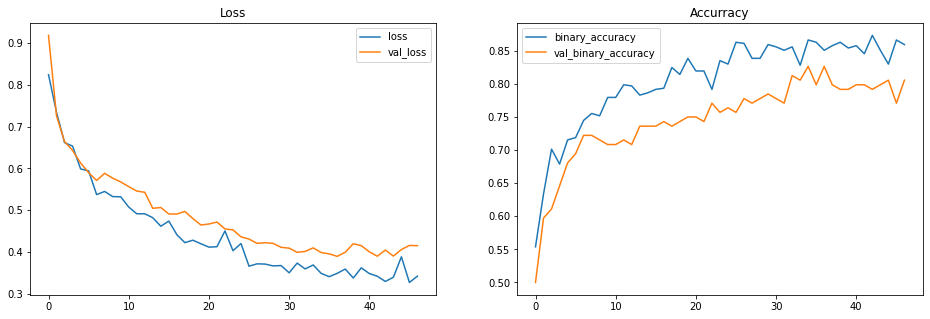

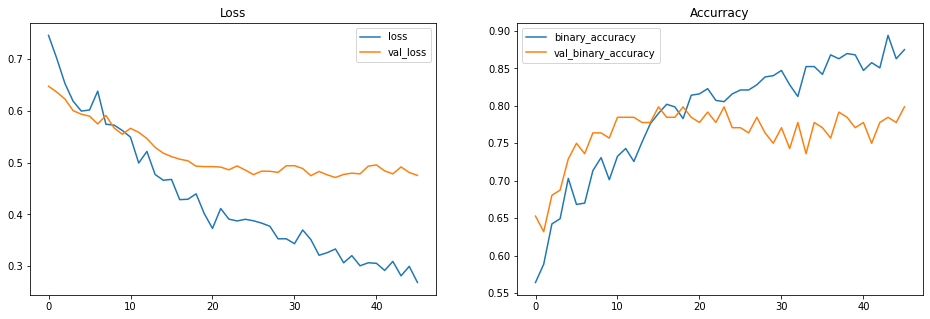

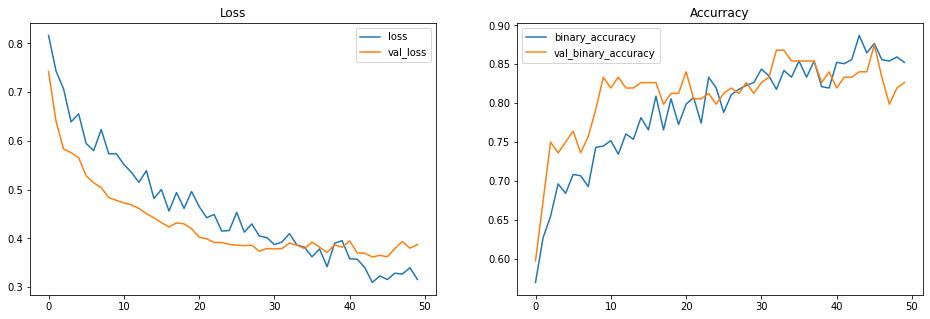

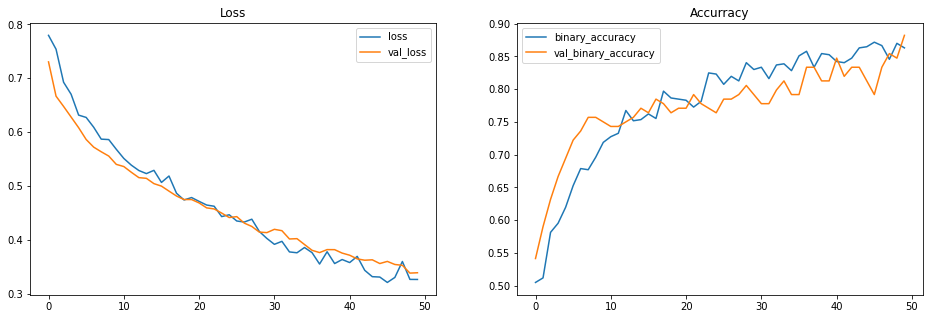

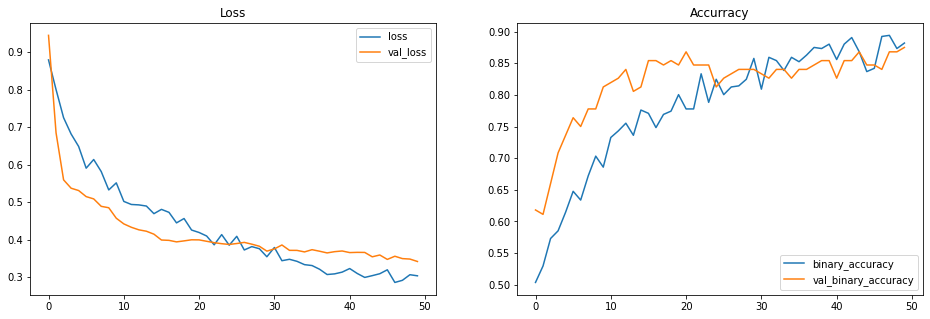

In [166]:
TRAIN_ACCURACY = []
TRAIN_LOSS = []

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

fold = 1

showArchitecture = True

#kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 7)
idg = ImageDataGenerator(rescale=1 / 255.0)

tf.keras.backend.clear_session()

for train_index, validation_index in skf.split(np.zeros(y.shape[0]), y):

    training_data = df.iloc[train_index]
    validation_data = df.iloc[validation_index]
    
    train_data_generator = idg.flow_from_dataframe(training_data, directory = UTSigPath,
                                                   x_col = 'filename', y_col = 'class',
                                                   class_mode = 'raw', shuffle = True, 
                                                   color_mode='rgb', target_size=(img_width, img_height))
    
    validation_data_generator  = idg.flow_from_dataframe(validation_data, directory = UTSigPath,
                                                         x_col = 'filename', y_col = 'class',
                                                         class_mode = 'raw', shuffle = True,
                                                         color_mode='rgb', target_size=(img_width, img_height))
    
    ######## Building model ########

    model = create_model(pretrained_base_name = 'inception_v1')

    ######## Displaying the model's architecture ########

    #if(showArchitecture):
    #    showArchitecture = False
    #    print('\n')
    #    print('\n################## Model''s architecture ##################\n'.format(fold))
    #    model.summary()
    #    print('\n')

    print('\n##############################################')
    print('################### Fold #{} ##################'.format(fold))
    print('##############################################\n')

    ######## Adding Early Stopping ########

    # These parameters say: "If there hasn't been at least an improvement of 0.001 in the validation 
    # loss over the previous 20 epochs, then stop the training and keep the best model you found."

    early_stopping = keras.callbacks.EarlyStopping(
        patience=10, # how many epochs to wait before stopping
        min_delta=0.001, # minimium amount of change to count as an improvement
        restore_best_weights=True,
    )

    ######## Saving Model ########

    # Create a callback that saves the model's weights

    checkpoint_path = modelsPath + os.sep +'inception_v1.ckpt'

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      verbose=1,
                                                      monitor='val_binary_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

    ######## Creating callbacks list ########

    callbacks_list = [early_stopping, cp_callback]

    ######## Fitting the model ########

    history = model.fit(
        train_data_generator,
        validation_data=validation_data_generator,
        batch_size=128,
        epochs=50,
        callbacks=callbacks_list
    )
    
    ######## Plotting losses ########

    history_df = pd.DataFrame(history.history)
    #print(history_df.columns.tolist())
    #history_df.loc[:, ['loss', 'val_loss']].plot()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

    axes[0].plot(history_df.loc[:, 'loss'], label='loss')
    axes[0].plot(history_df.loc[:, 'val_loss'], label='val_loss')
    axes[0].set_title('Loss')
    axes[0].legend()

    axes[1].plot(history_df.loc[:, 'binary_accuracy'], label='binary_accuracy')
    axes[1].plot(history_df.loc[:, 'val_binary_accuracy'], label='val_binary_accuracy')
    axes[1].set_title('Accurracy')
    axes[1].legend()

    ######## Load best model ########

    model.load_weights(checkpoint_path).expect_partial()
    
    ######## Evaluating the model ########

    # with train data

    results = model.evaluate(train_data_generator)
    results = dict(zip(model.metrics_names, results))
    TRAIN_ACCURACY.append(results['binary_accuracy'])
    TRAIN_LOSS.append(results['loss'])

    # with validation data

    results = model.evaluate(validation_data_generator)
    results = dict(zip(model.metrics_names, results))
    VALIDATION_ACCURACY.append(results['binary_accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold += 1

In [167]:
TRAIN_ACCURACY

[0.9045138955116272,
 0.8767361044883728,
 0.9409722089767456,
 0.9340277910232544,
 0.9548611044883728]

In [168]:
TRAIN_LOSS

[0.26280733942985535,
 0.3607969582080841,
 0.23102405667304993,
 0.23760952055454254,
 0.19742947816848755]

In [169]:
VALIDATION_ACCURACY

[0.8263888955116272, 0.7986111044883728, 0.875, 0.8819444179534912, 0.875]

In [170]:
VALIDATION_LOSS

[0.3986905515193939,
 0.5118420720100403,
 0.3626598119735718,
 0.33929601311683655,
 0.34207046031951904]

In [171]:
df = pd.DataFrame([])
df['train accuracy'] = TRAIN_ACCURACY
df['train loss'] = TRAIN_LOSS
df['validation accuracy'] = VALIDATION_ACCURACY
df['validation loss'] = VALIDATION_LOSS
np.round(df.mean(),2)

train accuracy         0.92
train loss             0.26
validation accuracy    0.85
validation loss        0.39
dtype: float64

In [174]:
# Fake signature detection example 

model = create_model()
model.load_weights(checkpoint_path).expect_partial()

img = keras.preprocessing.image.load_img(
    generalPath + os.sep.join(['Dataset preprocessing', datasetName, 'Opposite Hand_1_1.png'])
    , target_size=(img_width, img_height, 3)
    , color_mode="rgb"
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

img_array = img_array / 255.0

predictions = model.predict(img_array)
print(predictions)

[[0.01908275]]


In [175]:
# Genuine signature detection example 

img = keras.preprocessing.image.load_img(
    generalPath + os.sep.join(['Dataset preprocessing', datasetName, '1_1.png'])
    , target_size=(img_width, img_height, 3)
    , color_mode="rgb"
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

img_array = img_array / 255.0

predictions = model.predict(img_array)
print(predictions)

[[0.45285293]]
